# Выбор локации для скважины

Допустим, вы работаете в добывающей компании. Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# План проекта

1. Загрузим и подготовим данные
  - Изучим данные
  - Проверим корреляцию
  - Напишем функцию отделения целевого и ненужных признаков и разделения на обучающую и валидационную выборки
  - Создадим пайплайн масштабирования и обучения модели линейной регрессии
2. Обучим и проверим модель для каждого региона
  - Применим наши функции к данным каждого региона
  - Сохраним правильные ответы и предсказания на валидационной выборке
  - Выведем средний запас предсказанного сырья и RMSE модели и проанализируем результаты
3. Подготовимся к расчету прибыли
  - Сохраним все ключевые значения для расчетов в отдельных переменных
  - Рассчитаем достаточный объем сырья для безубыточной разработки скважины и сравним со средним запасом в каждом регионе
  - Напишем промежуточный вывод
4. Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели
  - Выберем 200 скважин с максимальными значениями предсказаний
  - Просуммируем целевое значение объема сырья, соответствующее этим предсказаниям
  - Рассчитаем прибыль для полученного объема сырья
5. Посчитаем риски и прибыль для каждого региона
  - Применим технику `Bootstrap` с `1000` выборок, чтобы найти распределение прибыли
  - Найдем среднюю прибыль, 95%-й доверительный интервал и риски убытков.
6. Напишем вывод, предложим регион для разработки

**Наша цель - определить оптимальный регион с точки зрения потенциальной прибыли и рисков**

## Загрузка и подготовка данных

### Импортируем необходимые библиотеки

In [1]:
!pip -q install -U scikit-learn
!pip -q install imblearn
!pip install -q fast_ml

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from scipy.stats import randint
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

### Загрузим и изучим данные

In [3]:
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

Создадим словарь с нашими датафреймами

In [4]:
df_dict = {
    'df_1' : df_1,
    'df_2' : df_2,
    'df_3' : df_3
}

Напишем функцию, принимающую на вход имя функции и выводящая результат ее применения для каждого датафрейма в нашем списке

In [5]:
def get_info(func, title=''):
    for name, df in df_dict.items():
        print(title, name)
        display(func(df))

Выведем первые 5 строк наших датафреймов

In [6]:
get_info(lambda df: df.head())

 df_1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


 df_2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


 df_3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
get_info(lambda df: df.shape, 'Размер')

Размер df_1


(100000, 5)

Размер df_2


(100000, 5)

Размер df_3


(100000, 5)

In [8]:
get_info(lambda df: df.info())

 df_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

 df_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

 df_3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [9]:
get_info(lambda df: df.describe().T)

 df_1


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


 df_2


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


 df_3


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Проверим корреляцию между признаками в нашем датафрейме

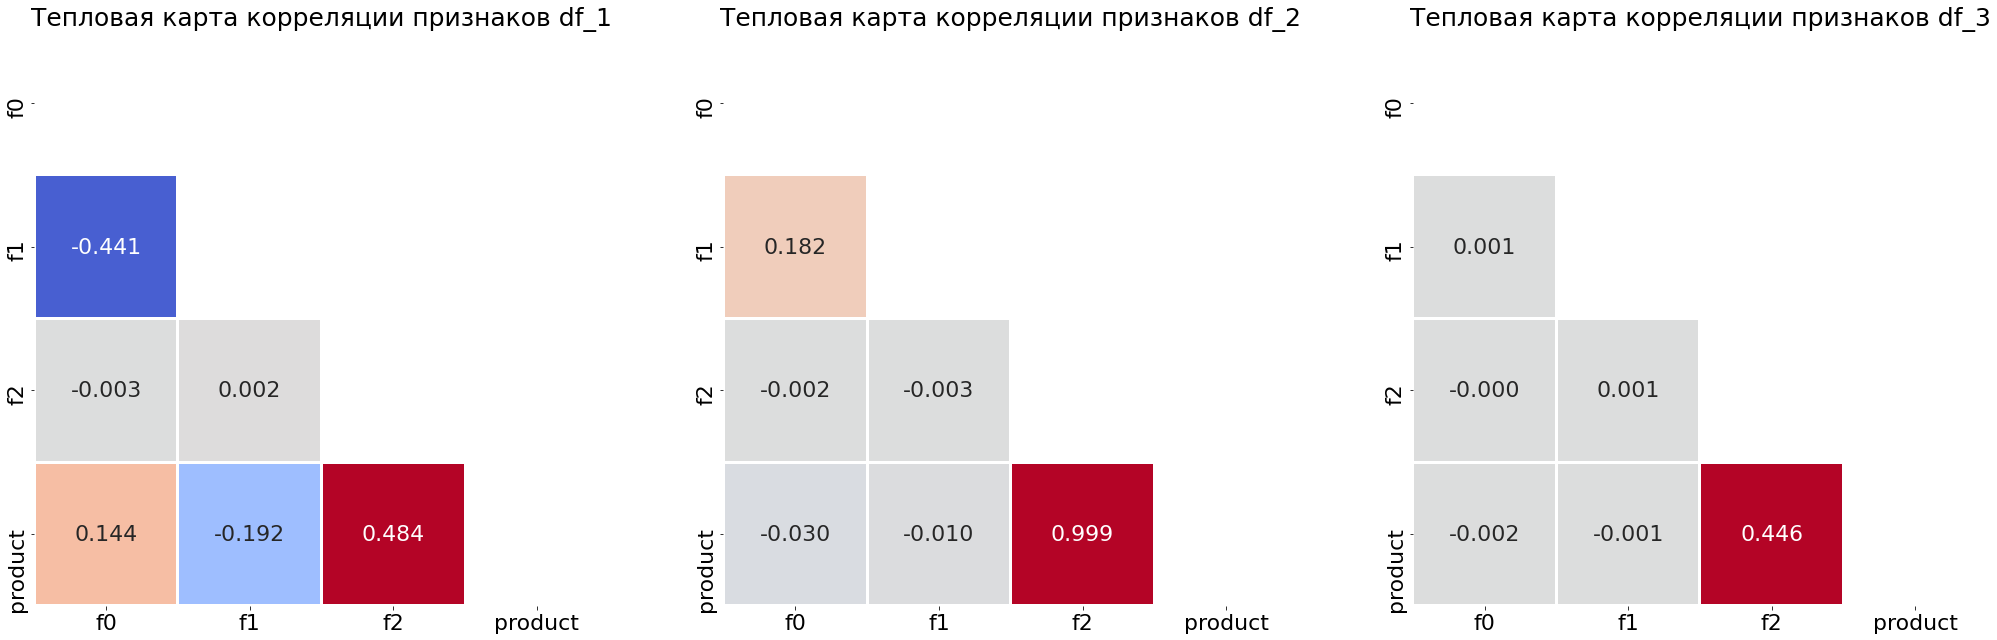

In [10]:
fig, axs = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(35, 14)
j = 0
for name, df in df_dict.items():
    mask = np.triu(df.corr())
    ax = sns.heatmap(df.corr(), annot=True, fmt='.3f', linewidths=2, mask=mask, annot_kws={"size":22},
                     square=True, cmap='coolwarm', cbar=False, center=0, ax=axs[j])
    axs[j].xaxis.set_tick_params(labelsize=22) 
    axs[j].yaxis.set_tick_params(labelsize=22)
    axs[j].set_title(f'Тепловая карта корреляции признаков {name}', fontsize=25)
    
    j += 1

Проверим на наличие строк дубликатов

In [11]:
get_info(lambda df: df.duplicated().sum(), 'Количество строк-дубликатов в')

Количество строк-дубликатов в df_1


0

Количество строк-дубликатов в df_2


0

Количество строк-дубликатов в df_3


0

### Промежуточный вывод

Мы загрузили и изучили данные

- В данных присутствуют информация о характеристиках скважин и объеме запасов нефти в трех регионах.
- Пропусков и дубликатов в данных нет
- Так как данные сентетические, мы не можем оценить реалистичность показателей и определить аномалии, будем считать, что раз данные сентетические, аномалий в них нет
- Проверили корреляцию между признаками
  + В первом регионе наблюдается слабая корреляция между признаками `f0` и `f1`. Так как корреляция недостаточно высокая чтобы однозначно утверждать о риске мультиколлинеарности, а признаков для обучения всего 3, отбрасывать один из них не будем. 
  + Во всех трех регионах имеется корреляция между обучающим признаков `f2` и целевым `product`. В 1 и 3 регионах корреляция слабая, а во 2 корреляция практически максимальная - `0.999`. Это может говорить о более высоком предсказательном потенциале модели для этого региона и, соответственном, наибольшем потенциале для разработки месторождений. Однако это предположение требует дальнейшей проверки  

### Подготовка данных

In [12]:
random_state = 1

Напишем функцию для отеделения целевого признака и разделения выборок на обучающую и валидационную

In [13]:
def split(df):
    """
    Функция отделяет целевой признак, отбрасывает `id`
    и разделяет данные на обучающую и валидационные выборки 
    """
        
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    f_train, f_valid, t_train, t_valid = (
        train_test_split(features, target, test_size=0.25, random_state=random_state))
    return f_train, f_valid, t_train, t_valid

Создадим пайплайн масштабирования данных и обучения модели

In [14]:
model = LinearRegression()

In [15]:
pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('Linear Regression', model)
                      ])

Напишем функцию для получения словаря с выборками

In [16]:
def get_dict(f_train, f_valid, t_train, t_valid):
    '''
    Функция возвращает словарь с образцами данных для обучения и тестирования модели.
    '''
    samples = {
        'features_train': f_train,
        'features_valid': f_valid,
        'target_train': t_train,
        'target_valid': t_valid,    
    }
    return samples

Напишем функцию для вывода размера выборок из переданного словаря

In [17]:
def get_size(samples):
    '''
    Функция выводит размеры выборок и соотношение классов (если выборка является pd.Series).
    '''
    for name, sample in samples.items():
        print(f'- Размер выборки {name}: {sample.shape}')

Напишем функцию-контейнер последовательно выполняющую предыдущие функции

In [18]:
def split_train_predict(df):
    """
    Функция выполняет разделение данных, масштабирование, обучение модели, предсказание на валидационной выборке
    и вычисление среднего запаса предсказанного сырья и RMSE модели.

    Parameters:
    df (pandas.DataFrame): Исходный набор данных.

    Returns:
    t_valid (pandas.Series): Валидационный целевой признак.
    predictions (pandas.Series): Предсказания модели.
    new_col (tuple): Кортеж с средними запасами предсказанного сырья и целевого сырья, и RMSE модели.
    """
    
    f_train, f_valid, t_train, t_valid = split(df)
    pipe.fit(f_train, t_train)
    predictions = pipe.predict(f_valid)
    
    print('Размер выборок:')
    get_size(get_dict(f_train, f_valid, t_train, t_valid))
    
    new_col = predictions.mean(), t_valid.mean(), np.sqrt(mean_squared_error(t_valid, predictions))
    predictions = pd.Series(predictions)
    t_valid = t_valid.reset_index(drop=True)
    
    return t_valid, predictions, new_col  

## Обучение и проверка модели

Создадим таблицу для добавления среднего объема предсказанного сырья и RMSE модели

In [19]:
comparison_regions = pd.DataFrame(index=['predict_mean', 'target_mean', 'rmse'])

Поочередно применим функцию-контейнер к данным каждого региона и сохраним правильные ответы,
предсказания и показатели для таблицы

In [20]:
t_valid_1, predictions_1, comparison_regions['region_1'] = split_train_predict(df_1);

Размер выборок:
- Размер выборки features_train: (75000, 3)
- Размер выборки features_valid: (25000, 3)
- Размер выборки target_train: (75000,)
- Размер выборки target_valid: (25000,)


In [21]:
t_valid_2, predictions_2, comparison_regions['region_2'] = split_train_predict(df_2);

Размер выборок:
- Размер выборки features_train: (75000, 3)
- Размер выборки features_valid: (25000, 3)
- Размер выборки target_train: (75000,)
- Размер выборки target_valid: (25000,)


In [22]:
t_valid_3, predictions_3, comparison_regions['region_3'] = split_train_predict(df_3);

Размер выборок:
- Размер выборки features_train: (75000, 3)
- Размер выборки features_valid: (25000, 3)
- Размер выборки target_train: (75000,)
- Размер выборки target_valid: (25000,)


Выведем нашу таблицу и изучим результаты

In [23]:
comparison_regions

,region_1,region_2,region_3
predict_mean,92.492625,69.120405,94.956830
target_mean,92.423414,69.117765,95.245631
rmse,37.742587,0.894338,39.866711


### Промежуточный вывод

На основе этих результатов можно сделать следующие выводы:

  - В регионе 2 модель показывает наиболее точное предсказание запасов с минимальным значением RMSE.
  - В регионах 1 и 3 модели имеют более высокие значения RMSE, что указывает на большую погрешность предсказания.
  - Средние объемы предсказанных и целевых запасов в каждом регионе достаточно близки.
  - Средние объемы запасов в 1 и 3 регионах практически идентичны и превосходят средние запасы во 2 регионе более чем на треть, однако, с учетом разницы в `RMSE`, для однозначного выбора наиболее перспективного региона требуется дальнейшее изучение

## Подготовка к расчёту прибыли

Создадим словарь хранящий название региона, предсказания и целевой признак

In [24]:
region_dict = {
    'region_1' : [predictions_1, t_valid_1],
    'region_2' : [predictions_2, t_valid_2],
    'region_3' : [predictions_3, t_valid_3],    
}

Зададим переменные, хранящие ключевые значения для расчетов

In [25]:
BUDGET = 10000000000 # Бюджет на разработку месторождений в регионе
REVENUE_PER_UNIT = 450000 # Доход с одной единицы продукта
TOTAL_FIELDS = 500 # Количество точек, исследуемых при разведке региона
SELECTED_FIELDS = 200 # Количество лучших точек, отбираемых по результатам разведки

Рассчитаем минимальный объем запасов одного месторождения для безубыточной разработки

In [26]:
min_volume = BUDGET / SELECTED_FIELDS / REVENUE_PER_UNIT

In [27]:
min_volume

111.11111111111111

In [28]:
comparison_regions

,region_1,region_2,region_3
predict_mean,92.492625,69.120405,94.956830
target_mean,92.423414,69.117765,95.245631
rmse,37.742587,0.894338,39.866711


### Промежуточный вывод

- Мы рассчитали минимальный объем месторождения для его безубыточной разработки исходя из бюджета на регион и количества разрабатываемых месторождений - `111.1`
- Средний запас в регионах 1 и 3 несколько меньше минимального, а во 2 регионе средний запас меньше в 1.5 раза, однако, потенциал добычи в регионе будет зависеть от способности отбирать лучшие месторождения

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели

In [29]:
def calculate_profit(predictions, target, count=SELECTED_FIELDS):
    """
    Функция отбирает заданное количество лучших месторождений на основе предсказаний
    и высчитывает прибыль в соответствии с целевыми значениями
    """
    
    probs_sorted = predictions.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return REVENUE_PER_UNIT * selected.sum()

Напишем функцию с использованием bootstrap для нахождения распределения прибыли 

In [30]:
def bootstrap(predictions, target, n=TOTAL_FIELDS):
    """
    Функция применяет технику Bootstrap с 1000 выборок с заданным количеством месторождений
    и применяет функцию calculate_profit для нахождения распределения прибыли 
    """

    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        target_subsample = target.sample(n=n, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        values.append(calculate_profit(predictions_subsample, target_subsample))
    values = pd.Series(values)
    return values

С помощью цикла рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона

In [31]:
comparison_regions_2 = pd.DataFrame(index=['mean_revenue', 'lower_bound_ci', 'upper_bound_ci', 'loss_risk'])

In [32]:
for name, data in region_dict.items():
    predictions, target = data
    values = bootstrap(predictions, target)
    loss_risk = ((values - BUDGET) < 0).mean() * 100
    new_col =(
        values.mean().round(0),
        values.quantile(0.025).round(0),
        values.quantile(0.975).round(0),
        str(f'{loss_risk} %')
    )
    comparison_regions_2[name] = new_col

In [33]:
comparison_regions_2.T

,mean_revenue,lower_bound_ci,upper_bound_ci,loss_risk
region_1,10458100402.0,9908061547.0,11015824889.0,4.6 %
region_2,10533609293.0,10098001407.0,10966461913.0,0.1 %
region_3,10426348386.0,9883377372.0,10980501750.0,6.1 %


## Вывод

В результате выполнения проекта исследованы 3 региона для разработки месторождений нефти. 
Несмотря на то, что средний запас месторождений в `регионе 2` значительно меньше чем в 2 других, модель на данных `региона 2` добилась значительно большой точности

|     | region_1 | region_2 | region_3 |
| --- | --- | --- | --- |
| predict_mean | 92.492625 | 69.120405 | 94.956830 |
| target_mean | 92.423414 | 69.117765 | 95.245631 |
| rmse | 37.742587 | 0.894338 | 39.866711 |

Применив технику Bootstrap, мы нашли распределение прибыли, 95% доверительный интервал и риск убытков

|     | mean_revenue | lower\_bound\_ci | upper\_bound\_ci | loss_risk |                        
| --- | --- | --- | --- | --- |
| region_1 | 10458100402.0 | 9908061547.0 | 11015824889.0 | 4.6 % |
| region_2 | 10533609293.0 | 10098001407.0 | 10966461913.0 | 0.1 % |
| region_3 | 10426348386.0 | 9883377372.0 | 10980501750.0 | 6.1 % |

`Регион 2` не только опередил два других региона по средней прибыли, но и продемонстрировал минимальный риск убытков по сравнению с остальными регионами. По условию задания, необходимо оставить только регионы, в которых вероятность убытков меньше `2.5%`. Таким образом, с учетом условий, `регион 2` не только наиболее перспективный, но и единственный кандидат на разработку скважин.